# Wei et al. - Gsdmd BBB
## Extended Data Figure Y - Cell Saturation

In [1]:
import pandas as pd
import numpy as np
import warnings
from scipy import io
import random as rd
import seaborn as sns
from matplotlib import rcParams

In [2]:
info=pd.read_csv("../data/processed/tmp/metadata.csv")

In [4]:
info.cell_type_brief.value_counts()

Som       2943
Cort       653
Lac        639
Gonad      334
WBCs       251
Mel        226
Endo       155
Ambig      135
Stem       132
Thyro      111
Pou1f1     101
Pitui       76
RBCs        76
Peri        71
Name: cell_type_brief, dtype: int64

In [6]:
info2=info.loc[:,["cell_id","cell_type_brief","nFeature_RNA"]]
info2.columns=['Sample','cell_type_brief',"nFeature_RNA"]

In [8]:
# df=pd.read_csv("../data/sc/int_300G/counts_cuc.csv", index_col=0)

## Could have used sparse matrix as well
mtx=io.mmread('../data/processed/tmp/counts.mtx')
df=pd.DataFrame(mtx.todense())

过滤reads<3 的基因。  
Filtering genes with reads < 3.

In [9]:
df2=df.applymap(lambda x:0 if x<3 else 1)

In [15]:
## In case the cell ids don't match
df2.columns = info2['Sample'].tolist()

In [23]:
# info2['nFeatures_filtered'] = df2.sum(axis=0).tolist()

In [10]:
warnings.filterwarnings("ignore")

def get_gene(data,cells):
    sdata=data.iloc[:,rd.sample(range(0,data.shape[1]),cells)]
    out=sdata.sum(axis=1)
    return out[out>0].shape[0]

def SaturationRes(data,steps=10,maxcells=np.nan):
    total_cells=data.shape[1]
    if np.isnan(maxcells):
        use_cells=total_cells
    else:
        use_cells=min(total_cells,maxcells)
    interval = use_cells//steps
    resdict={}
    
    for x in range(interval,use_cells,interval):
        resdict[x]=get_gene(data,x)
    for x in range(10,min(resdict.keys()),50):
        resdict[x]=get_gene(data,x)
    resdict[0]=0
    resdict[use_cells]=get_gene(data,use_cells)
    out=pd.Series(resdict).to_frame("Gene")
    out.index.name="Cells"
    return out.reset_index()

def Group_Saturation(alldata,allinfo,tag,repeat=1,**kwargs):
    samples=allinfo[allinfo.iloc[:,1]==tag].Sample
    inputdata=alldata.loc[:,samples]
    n=0
    out=pd.DataFrame()
    while n<repeat:
        tmp=SaturationRes(inputdata,**kwargs)
        out=out.append(tmp)
        n+=1
    out.loc[:,'Group']=tag
    return out.sort_values(['Group','Cells'])

In [18]:
res2=pd.DataFrame()
for i in info2.cell_type_brief.unique():
    tmp=Group_Saturation(df2,info2,i,maxcells=3000,steps=10,repeat=50)
    res2=res2.append(tmp)

KeyboardInterrupt: 

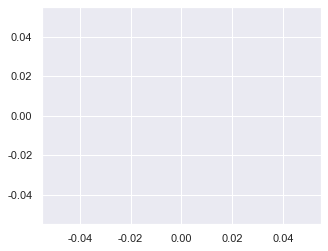

In [70]:
# res2=res2.rename(columns={'Group':'cell_type_brief'})
# with sns.axes_style("whitegrid"):
#     sns.set(rc={'figure.figsize':(6,5)})
#     rcParams['figure.figsize'] = 5,4
#     rcParams["font.family"] = "Arial"
#     rcParams["legend.title_fontsize"]=13
#     rcParams['pdf.fonttype'] = 42
#     rcParams['ps.fonttype'] = 42
#     rcParams['axes.titlesize']=17
#     rcParams['font.size']=15
#     rcParams['axes.unicode_minus']=False
#     g=sns.lineplot(x="Cells",y='Gene',hue='cell_type_brief',data=res2)
#     g.set_xlabel("Number of Cells considered")


In [19]:
res2.to_csv("../outs/saturation_maxc_3000_s_10_r_50.csv")